In [1]:
import os
import re
import pandas
from custom_dataset import NaturalBench
import numpy as np
from eval import extract_answer, get_scores
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Please install pyav to use video processing functions.
OpenCLIP not installed


In [2]:
outputs_folder = "outputs"
filenames_out_7b = list(filter(lambda o: re.match("^\d*\.csv$", o), os.listdir(outputs_folder)))
filenames_out_05b = list(filter(lambda o: re.match("^05b_\d*\.csv$", o), os.listdir(outputs_folder)))

In [4]:
n_samples = 7600
answers = {i: [] for i in range(n_samples)}
for filename in filenames_out_05b:
    full_path = os.path.join(outputs_folder, filename)
    with open(full_path, 'r') as out_file:
        lines = out_file.readlines()
    for line in lines:
        parts = line.split(',')
        index = parts[0]
        ans = ",".join(parts[1:])
        answers[int(index)].append(ans)

In [5]:
dataset = NaturalBench()

100%|████████████████████████████████████████████████████████████████████████████| 1900/1900 [00:34<00:00, 54.67it/s]


In [10]:
def majority_voting(answers, task_type='yes_no'):
    parsed_answers = []
    for ans in answers:
        parsed_ans = extract_answer(ans, task_type=task_type)
        if parsed_ans >= 0: parsed_answers.append(parsed_ans)
    count_0 = parsed_answers.count(0)
    count_1 = parsed_answers.count(1)
    total = count_0+count_1
    if total == 0:
        return [0,0]
    return [count_0/total, count_1/total]

def majority_voting_answer(answers, task_type='yes_no', biais_correction=(0,0)):
    """
    returns a single answer computed by majority voting.
    biais correction = (correction for "No", correction for "A") will be added to 
    respectively No and A scores. Eg:
    before correction: {
        "Yes": 0.6
        "No": 0.4
    }
    correction = (0.25, 0.1)
    after correction: {
        "Yes": 0.6
        "No": 0.65
    }
    """
    survey_results = majority_voting(answers, task_type=task_type)
    # correct biais (add to No and A)
    if task_type == 'yes_no':
        correction  = biais_correction[0]
        survey_results[0] += correction
    else:
        correction = biais_correction[1]
        survey_results[1] += correction
    return int(np.argmax(survey_results))

In [8]:
majority_voting(answers[0], task_type=dataset[0][3])

[0.0, 1.0]

In [7]:
majority_voting_answer(answers[0], task_type=dataset[0][3])

1

In [11]:
majority_answers = [majority_voting_answer(answers[i], task_type=dataset[i][3]) for i in range(n_samples)]

In [12]:
# make groups of 4 and compute scores
majority_answers_groups = [
    [majority_answers[i*4], majority_answers[i*4+1], majority_answers[i*4+2], majority_answers[i*4+3]] 
    for i in range(len(majority_answers)//4)
]

In [13]:
get_scores(majority_answers_groups)

{'Q_Acc': 0.41289473684210526,
 'I_Acc': 0.40210526315789474,
 'Acc': 0.665,
 'G_Acc': 0.13894736842105262}

In [11]:
def scores_from_biais(biais):
    majority_answers = [majority_voting_answer(answers[i], task_type=dataset[i][3], biais_correction=biais) for i in range(n_samples)]
    majority_answers_groups = [
        [majority_answers[i*4], majority_answers[i*4+1], majority_answers[i*4+2], majority_answers[i*4+3]] 
        for i in range(len(majority_answers)//4)
    ]
    return get_scores(majority_answers_groups)

In [61]:
scores_from_biais((0, 0))

{'Q_Acc': 0.5965789473684211,
 'I_Acc': 0.6192105263157894,
 'Acc': 0.7898684210526316,
 'G_Acc': 0.3394736842105263}

In [27]:
# plot acc as a function of bias
no_biases = np.arange(0,1,0.05)
a_biases = np.arange(0,1,0.05)
accuracies = np.zeros((no_biases.shape[0],a_biases.shape[0]), dtype=float)
for i, no_bias in tqdm(enumerate(no_biases), total=20):
    for j, a_bias in enumerate(a_biases):
        acc = scores_from_biais((no_bias, a_bias))['Acc']
        accuracies[i,j] = acc

100%|█████████████████████████████████████████████████████████████████████| 20/20 [03:48<00:00, 11.42s/it]


In [35]:
# reverse the y axis for plotting
accuracies = np.flip(accuracies, axis=1)

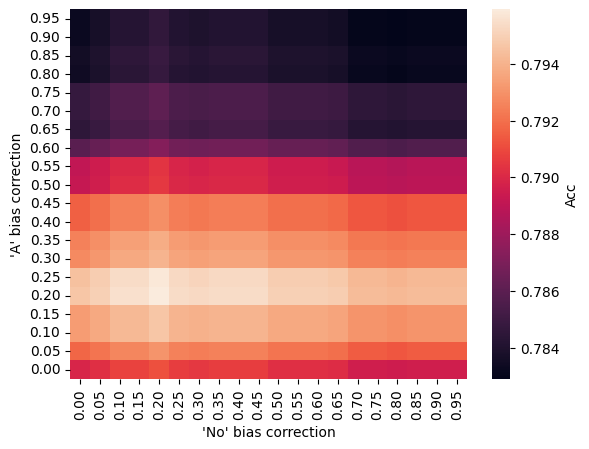

In [60]:
plot = sns.heatmap(
    accuracies,
    xticklabels=[f"{no_bias:.2f}" for no_bias in no_biases],
    yticklabels=[f"{a_bias:.2f}" for a_bias in a_biases][::-1],
    cbar_kws={"label": "Acc"}
)
plot.set(xlabel="'No' bias correction", ylabel="'A' bias correction")
plot.get_figure().savefig("bias_heatmap.jpg", dpi=500, bbox_inches="tight")

<Axes: >

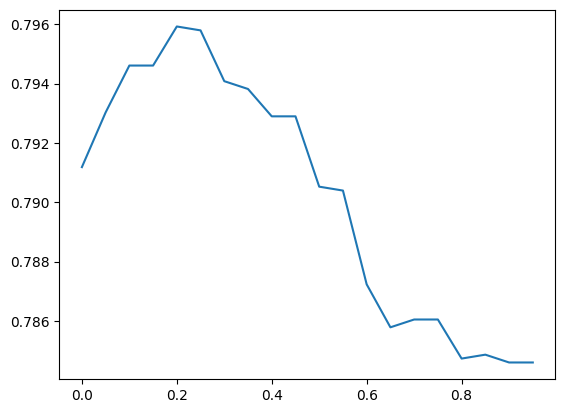

In [50]:
sns.lineplot(x=no_biases, y=accuracies[:, 4][::-1])

In [56]:
scores_from_biais((1, 0.2))

{'Q_Acc': 0.16815789473684212,
 'I_Acc': 0.1694736842105263,
 'Acc': 0.5823684210526315,
 'G_Acc': 0.11578947368421053}

In [14]:
def scores_from_first_n(n=33, correction=(0,0)):
    reduced_answers = [ans[:n] for ans in answers.values()]
    majority_answers = [majority_voting_answer(reduced_answers[i], task_type=dataset[i][3], biais_correction=correction) for i in range(n_samples)]
    majority_answers_groups = [
        [majority_answers[i*4], majority_answers[i*4+1], majority_answers[i*4+2], majority_answers[i*4+3]] 
        for i in range(len(majority_answers)//4)
    ]
    return get_scores(majority_answers_groups)

In [15]:
x = np.arange(1, 22, 1)
y = [scores_from_first_n(n=n) for n in x]

In [17]:
y = [val['Acc'] for val in y]

In [99]:
y_bias_corrected = [scores_from_first_n(n=n, correction=(0.2,0.2))['Acc'] for n in x]

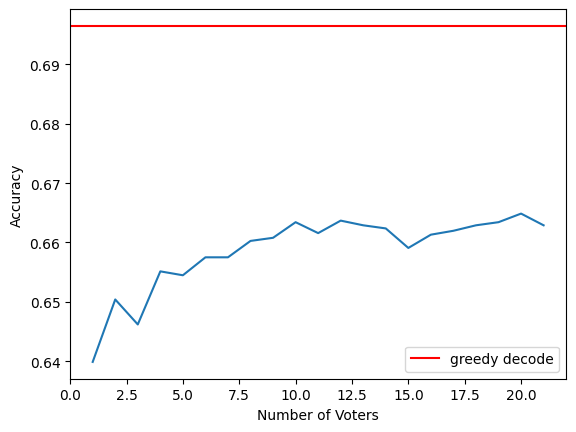

In [20]:
plot = sns.lineplot(x=x,y=y)
plt.axhline(y=0.6965, c='r', linestyle="-", label="greedy decode")
plt.legend()
plot.set(xlabel="Number of Voters", ylabel="Accuracy")
plot.get_figure().savefig("majority_results.jpg", dpi=500)